# Introducción


Somos Lorena Gallego, Ignacio García y Aitor Chamizo. En este proyecto, nos proponemos modelar un clasificador para tumores primarios con el objetivo de aplicar los conocimientos de la asignatura Inteligencia Artificial y Aprendizaje, del grado en Ingeniería Biomédica (Universidad Rey Juan Carlos).

A continuación, procedemos a analizar la base de datos con la que vamos a trabajar.

La base de datos que hemos elegido es un conjunto de datos muy conocido acerca de **tumores primarios**. 
Esta base de datos está compuesta por **variables categóricas** principalmente, de tipo **multivariante**. Por tanto, a priori, el análisis que realizaremos será de **clasificación**.

El **número de pacientes** que tenemos es de **339** mientras que el **número de atributos** es de **18**. Tenemos un total de 225 valores perdidos entre todas las categorías y pacientes.

La fecha en la que se recogió esta base de datos es el 1 de noviembre de 1988, en el **instituto de Oncología** del centro médico universitario de **Liubliana, Eslovenia** (antigua Yugoslavia).

Los **atributos** con los que se van a trabajar son:   
-Clase de tumor   
-Edad del paciente   
-Sexo del paciente    
-Tipo histológico del tumor    
-Grado de diferenciación (parecido con las células de alrededor)   
-Lugar de inicio (hueso, pleura, médula ósea, pulmón, pleura pulmonar, peritoneo, hígado, cerebro, piel, región supraclavicular, región axilar, mediastino o región abdominal).

Un **tumor primario** es un tumor que crece en el sitio anatómico en el que empezó la progresión y procede a crear una masa cancerosa, sin metástasis. *Esta es la principal diferencia con los tumores secundarios*, que son aquellos que se distribuyen por otras partes del cuerpo.


Podemos ver que la distribución en las 22 clases no es uniforme, es decir, no está equilibrada, en la distribución de clases que se indica en el archivo primary-tumor.names .


# Código de análisis: Visualización de datos.
---



In [ ]:
#A continuación, procedemos a leer la base de datos para ver qué aspecto tiene y cómo podemos trabajar
#con bases de datos tipo .data. 
import pandas as pd 
import statistics as stats
import sklearn.model_selection as skm
columnas = ['class', 'age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura', 'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal']
file = pd.read_csv('primary-tumor.data', sep=',', names = columnas) #Leemos el archivo como si fuese un CSV
#Tal y como se advertía en la página web de la que obtuvimos los datos, el nombre de las variables 
#viene dado con números
#Procedemos a cambiar el nombre de las columnas, para que sea más fácil determinar a qué se refiere
#cada atributo.
#Separamos los datos en training y test para preprocesar training.


 # Código de preprocesado: Integración, limpieza, transformación y reducción de los datos
---


A continuación, procedemos a preprocesar los datos que tenemos para quedarnos con los elementos óptimos de la base y poder clasificar de la mejor manera posible.

In [ ]:
#Empezaremos viendo qué aspecto tienen los datos. Para ello, procedemos a 
#importar algunas librerias
import sklearn as sk
import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns
import scipy as sc
import random
!pip install miceforest 
import miceforest as mf




     |████████████████████████████████| 69 kB 3.5 MB/s 


Limpieza de datos

In [ ]:
#Como se puede ver, por haber valores NaN, no calcula los estadísticos de algunas de las columnas.
file = file.replace('?', np.nan)

#La primera aproximación que utilizamos fue intentar imputar el mejor valor para cada tipo de cáncer [1],[2],[3],[4],[5]. 
#Después, investigamos varios tipos de técnicas para eliminar estos valores [6], [7].

#Finalmente, decidimos emplear el algoritmo MICE (multiple imputation by chained equations) para tratar los missing values.
#Para aquellas categorías con solo un valor perdido, asumiremos que se ha perdido de forma aleatoria (Missing Completely at Random) 
#En el resto de casos, que son dos variables, observamos un porcentaje bastante alto de valores perdidos. Dado que parece que
#son variables bastante importantes para predecir la aparición de tumores primarios en la literatura,
#optamos por no eliminarlos.


#Creamos el kernel de MICE, con cuatro datasets para poder comparar en gráficas con valores imputados diferentes.
#En primer lugar, convertimos todas las variables en categóricas (en pandas están definidas como int64). [8]
for col in columnas:
    file[col] = file[col].astype('category',copy=False)
#Proseguimos con el algoritmo.
kernel = mf.ImputationKernel(
  file,
  save_all_iterations=True,
  random_state=1
)
kernel.mice(3)
completed_dataset = kernel.complete_data(dataset=0, inplace=False) #completed_dataset pasa a ser el nuevo archivo
#con el que trabajamos
print(completed_dataset.isnull().sum(0))

#kernel.plot_imputed_distributions(wspace=0.35,hspace=0.4)
completed_dataset.head(20) #para comprobar que el print anterior es real.

class              0
age                0
sex                0
histologic-type    0
degree-of-diffe    0
bone               0
bone-marrow        0
lung               0
pleura             0
peritoneum         0
liver              0
brain              0
skin               0
neck               0
supraclavicular    0
axillar            0
mediastinum        0
abdominal          0
dtype: int64


,class,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,abdominal
0,1,1,1,2,3,2,2,1,2,2,2,2,2,2,2,2,2,2
1,1,1,1,3,3,2,2,2,2,2,1,2,2,2,1,2,1,2
2,1,1,2,2,3,1,2,2,2,2,2,2,2,2,2,2,1,2
3,1,1,2,2,3,1,2,1,1,2,2,2,2,2,2,2,1,2
4,1,1,2,2,3,1,2,1,1,2,2,2,2,2,2,2,1,2
5,1,1,2,3,3,1,2,2,2,2,2,1,2,2,1,1,1,2
6,1,2,1,1,1,1,2,2,2,2,2,2,1,1,1,2,2,2
7,1,2,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2
8,1,2,1,1,1,2,2,2,2,2,2,2,2,1,2,2,2,2
9,1,2,1,1,2,1,2,2,2,2,2,2,1,1,1,2,2,2


Transformación de datos.

In [ ]:
#Dado que no tener los datos en una base 0/1/2... puede afectar a los valores de ciertas correlaciones, 
#(método de Kendall, que usaremos más adelante) pasamos a transformar los datos para obtener el resultado más preciso posible.

clase=completed_dataset["class"]
input = completed_dataset.drop(columns='class')
columna_sin_clase = ['age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura', 'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal']
for col in columna_sin_clase:
    input[col] = input[col].astype('int64',copy=False)
input = input.replace(to_replace = 1, value = 0, regex = True)
input = input.replace(to_replace = 2, value = 1, regex = True)
input = input.replace(to_replace = 3, value = 2, regex = True)

completed_dataset=input
completed_dataset["class"]=clase

input.head(20)




,age,sex,histologic-type,degree-of-diffe,bone,bone-marrow,lung,pleura,peritoneum,liver,brain,skin,neck,supraclavicular,axillar,mediastinum,abdominal,class
0,0,0,1,2,1,1,0,1,1,1,1,1,1,1,1,1,1,1
1,0,0,2,2,1,1,1,1,1,0,1,1,1,0,1,0,1,1
2,0,1,1,2,0,1,1,1,1,1,1,1,1,1,1,0,1,1
3,0,1,1,2,0,1,0,0,1,1,1,1,1,1,1,0,1,1
4,0,1,1,2,0,1,0,0,1,1,1,1,1,1,1,0,1,1
5,0,1,2,2,0,1,1,1,1,1,0,1,1,0,0,0,1,1
6,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,1
7,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
8,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1
9,1,0,0,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73d173e610>,
      dtype=object)

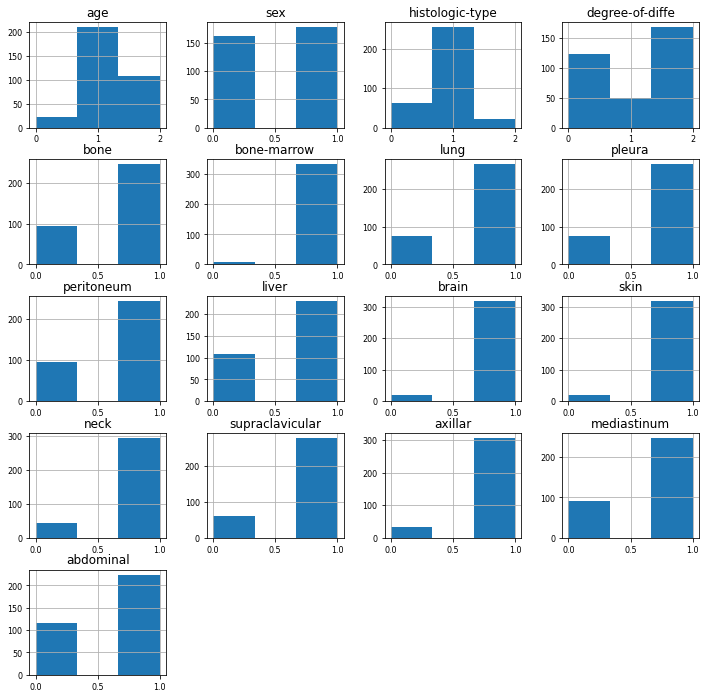

In [ ]:
completed_dataset.hist(figsize=(12, 12), bins=3, xlabelsize=8, ylabelsize=8) 
#Podemos ver que los atributos están desbalanceados, es decir, a excepción del sexo hay muchos atributos con más valores de una categoría que de otra.
#Esto supone una limitación para nuestro estudio y nuestro clasificador, que solventaremos en futuras versiones mediante un oversampling/undersampling
#(es decir, usando pacientes artificiales).

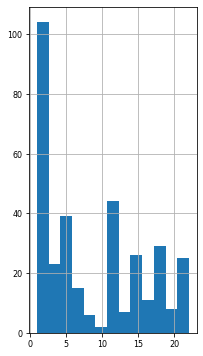

In [ ]:
completed_dataset["class"].hist(figsize=(3, 6), bins=13, xlabelsize=8, ylabelsize=8)
#Podemos ver además que las clases están desbalanceadas. Con el método que especificamos anteriormente, trataremos de solventar esta incidencia en futuras versiones.
#De momento, asumiremos el coste de este desbalanceo en la precisión y r2 score de nuestro algoritmo.

Fase de reducción de datos

In [ ]:
##FASE DE REDUCCIÓN DE DATOS

import scipy.stats as stats
#Calculamos el estadístico Phi de Cramer, que es una variante del t de Student
#para variables discretas ordinales.
X2 = stats.chi2_contingency(input, correction=False)[0]
n = np.sum(input)
minDim = min(input.shape)-1


V = np.sqrt((X2/n) / minDim)

print(V)

#Aquí calculamos una correlación. Este estimador tiene bastante sesgo, por eso
#buscaremos complementar estos datos con los propios del método de Kendall.


age                0.621783
sex                0.961219
histologic-type    0.740799
degree-of-diffe    0.652594
bone               0.817007
bone-marrow        0.701843
lung               0.787058
pleura             0.787058
peritoneum         0.818679
liver              0.843228
brain              0.717126
skin               0.717126
neck               0.744557
supraclavicular    0.766984
axillar            0.731052
mediastinum        0.813692
abdominal          0.854446
dtype: float64


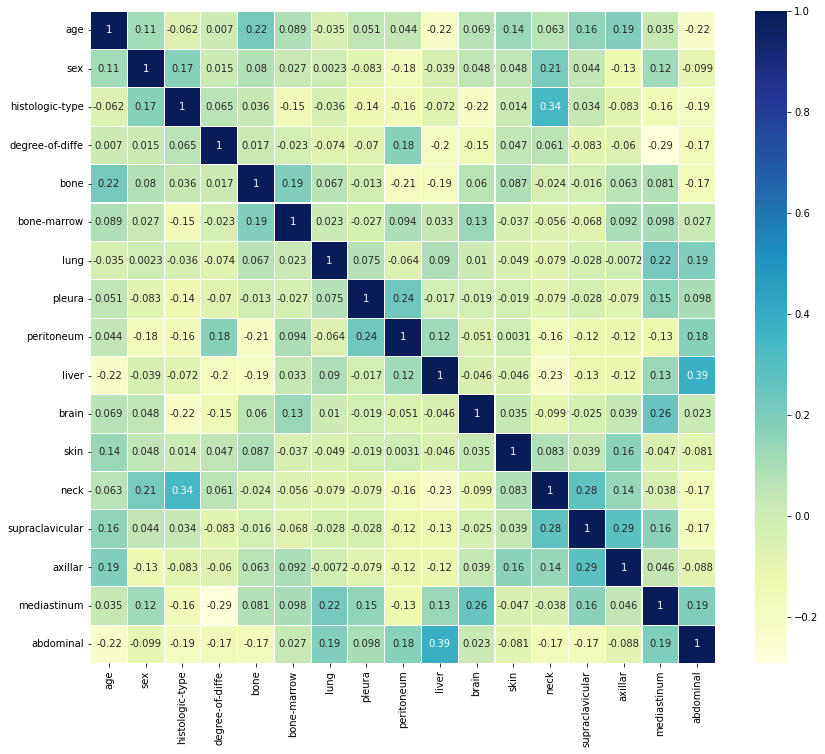

In [ ]:
plt.figure(figsize=(14,12))
sns.heatmap(input.corr(method = 'kendall'),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

#Aquí usamos el método de Kendall porque es un método que calcula correlación
#entre variables ordinales discretas. 
#Como podemos ver en el gráfico, ninguna variable muestra una correlación elevada como para considerar su eliminación
#Por tanto, lo dejamos tal y como está.
#Kendall es más robusto que la phi de Cramer porque las variables categóricas rara vez siguen una distribución normal


In [ ]:
#Para finalizar, observamos que en determinadas clases el número de 
#características es muy bajo.
#Para ello, procedemos a eliminar aquellas características con un valor
#de 0/1 y a agrupar aquellas (según criterios basados en la literatura
#científica) con valores inferiores a 6/7.

#Procedemos a eliminar la característica 'cáncer de ano'. 9
#Juntamos corpus uteri, cervix uteri y ovary [11] 19, 20, 18
#creando la clase 'cáncer de útero u ovario'.
#Eliminamos la característica 'cáncer de vagina' y 'cáncer de testículos'
#Juntamos 'cáncer de colon' y 'cáncer de recto'
#creando la clase 'cáncer colorectal'[12]
#Juntamos 'cáncer de vejiga' y 'cáncer de próstata'
#creando la clase 'cáncer de vejiga o próstata'[13]
#Eliminamos cáncer de duodeno y glándulas salivares por ser más raros
#tanto en número de pacientes como en prevalencia a nivel mundial.

#Para ello, efectuaremos todos los cambios en la variable de salida.
#Entendemos que esto supone cambiar los resultados que van a salir,
#pero es que esto es justo lo que buscamos
#Nuestra idea es juntar conjuntos de cáncer relacionados
#para evitar que métodos como la regresión logística
#escojan únicamente la clase más representada (es uno de sus 
#principales sesgos), así como eliminar aquellos que no predice o 
#predice con muy baja probabilidad.

#La nueva lista de clases es 
#pulmón, cabeza y cuello, esófago, tiroides, estómago, 
#colorectal, pancreas, vesícula biliar, hígado, riñón,
#vejiga o próstata, ovario/corpus uteri/cervix uteri, pecho.

completed_dataset[completed_dataset["class"] == 9]
#Como se puede ver, no hace falta eliminar el cáncer de ano.
completed_dataset[completed_dataset['class'] == 20] #Sabemos que los indices son 312 y 313
completed_dataset.at[313, 'class'] = 18
completed_dataset.at[312, 'class'] = 18
completed_dataset[completed_dataset['class'] == 19]
lista = [306, 307, 308, 309, 310, 311]
for i in range(len(lista)):
  completed_dataset.at[lista[i], 'class'] = 18
completed_dataset[completed_dataset['class'] == 21] #Vemos que es el 314 
#para cancer de vagina
completed_dataset.drop(314,axis=0, inplace=True) #Lo eliminamos, solo
#se ejecuta la primera vez
completed_dataset[completed_dataset['class'] == 16] #Vemos que es el 266 
#para el cancer de testiculos
completed_dataset.drop(266, axis = 0, inplace=True)
completed_dataset[completed_dataset['class'] == 8] #Vemos que cancer de 
#recto está aquí
lista = [181, 182, 183, 184, 185, 186]
for i in range(len(lista)):
  completed_dataset.at[lista[i], 'class'] = 7
completed_dataset[completed_dataset['class'] == 15] #Vemos que cáncer de 
#vejiga es 264 y 265
lista = [264, 265]
for i in range(len(lista)):
  completed_dataset.at[lista[i], 'class'] = 17



#completed_dataset[completed_dataset['class'] == 6] #Vemos que el 166 es para el cáncer de duodeno
completed_dataset.drop(166, axis = 0, inplace=True)


#completed_dataset[completed_dataset['class'] == 10] #Vemos que 187 y 188 son de 
#cáncer de glándulas salivares.
completed_dataset.drop(187, axis = 0, inplace=True)
completed_dataset.drop(188, axis = 0, inplace=True)

output = completed_dataset['class']
input = completed_dataset.drop(columns='class')
output.cat.remove_categories(removals = [6, 10, 20, 19, 21, 16, 8, 15], inplace = True)
#Finalmente, tenemos 13 categorías y una base de datos bastante más balanceada
#que la que teníamos. Aún así, sigue estando desbalanceada a favor del cáncer de
#pulmón; habrá que tenerlo en cuenta en futuros análisis.

Debido a que nuestra base de datos está compuesta de variables categóricas, no podemos realizar un estudio de outliers, ya que no tendría sentido clasificar datos de este tipo de variables como valores atípicos. Debido a esto, el preprocesado termina aquí. 

Bibliografía:
1. Li, X., Xu, H., Yan, L., Gao, J., & Zhu, L. (2021). A Novel Clinical Nomogram for Predicting Cancer-Specific Survival in Adult Patients After Primary Surgery for Epithelial Ovarian Cancer: A Real-World Analysis Based on the Surveillance, Epidemiology, and End Results Database and External Validation in a Tertiary Center. Frontiers in oncology, 11, 670644. https://doi.org/10.3389/fonc.2021.670644
2. Lee, C. C., Ho, H. C., Su, Y. C., Yu, C. H., & Yang, C. C. (2015). Modified Tumor Classification With Inclusion of Tumor Characteristics Improves Discrimination and Prediction Accuracy in Oral and Hypopharyngeal Cancer Patients Who Underwent Surgery. Medicine, 94(27), e1114. https://doi.org/10.1097/MD.0000000000001114
3. Schlageter, M., Terracciano, L. M., D'Angelo, S., & Sorrentino, P. (2014). Histopathology of hepatocellular carcinoma. World journal of gastroenterology, 20(43), 15955–15964. https://doi.org/10.3748/wjg.v20.i43.15955
4. Caratozzolo E, Massani M, Recordare A, Ciardo L, Antoniutti M, Jelmoni A, Bassi N. Squamous cell liver cancer arising from an epidermoid cyst. J Hepatobiliary Pancreat Surg. 2001;8(5):490-3. doi: 10.1007/s005340100015. PMID: 11702262.
5. Dhasade, G. (2020, November 14). Ways To Handle Categorical Column Missing Data & Its Implementations. Medium. https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893
6. Azur, M. J., Stuart, E. A., Frangakis, C., & Leaf, P. J. (2011). Multiple imputation by chained equations: what is it and how does it work?. International journal of methods in psychiatric research, 20(1), 40–49. https://doi.org/10.1002/mpr.329
7. Dolladille, C., Chrétien, B., Peyro-Saint-Paul, L. et al. Association Between Disease-Modifying Therapies Prescribed to Persons with Multiple Sclerosis and Cancer: a WHO Pharmacovigilance Database Analysis. Neurotherapeutics (2021). https://doi.org/10.1007/s13311-021-01073-y
8. miceforest. (2021, October 16). PyPI. https://pypi.org/project/miceforest/
9. Kinoshita Y, Singh A, Rovito PM Jr, Wang CY, Haas GP. Double primary cancers of the prostate and bladder: a literature review. Clin Prostate Cancer. 2004 Sep;3(2):83-6. doi: 10.3816/cgc.2004.n.016. PMID: 15479490.
10. Griffiths, C. D., McKechnie, T., Lee, Y., Springer, J. E., Doumouras, A. G., Hong, D., & Eskicioglu, C. (2021). Presentation and survival among patients with colorectal cancer before the age of screening: a systematic review and meta-analysis. Canadian journal of surgery. Journal canadien de chirurgie, 64(1), E91–E100. https://doi.org/10.1503/cjs.013019 
11. Wu, M., Gunning, W., & Ratnam, M. (1999, September). Expression of Folate Receptor Type α in Relation to Cell Type, Malignancy, and Differentiation in Ovary, Uterus, and Cervix. Cancer Epidemiology, Biomarkers and Prevention. Published. https://cebp.aacrjournals.org/content/8/9/775
12. Siegel, R.L., Miller, K.D., Goding Sauer, A., Fedewa, S.A., Butterly, L.F., Anderson, J.C., Cercek, A., Smith, R.A. and Jemal, A. (2020), Colorectal cancer statistics, 2020. CA A Cancer J Clin, 70: 145-164. https://doi.org/10.3322/caac.21601
13. Chun, T. Y. (1997). Coincidence of bladder and prostate cancer. Journal of Urology. Published. https://doi.org/10.1016/s0022-5347(01)65281-9

#Clasificación y regresión con variable sintética: regresión lineal y no lineal.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
#Para poder demostrar nuestros conocimientos sobre variable continua y 
#dado que toda nuestra base de datos es categórica, añadiremos
#una variable aleatoria continua denominada Proba-of-rec, que
#será una variable con datos del 1 al 100 que proporcionará
#valores numéricos sobre la probabilidad de recuperación del cáncer.
#Dado que es una variable sintética para poder efectuar regresiones lineales,
#no recomendamos sacar conclusiones aplicables a un contexto clínico.
input_lr = input
columna_sin_clase = ['age', 'sex', 'histologic-type', 'degree-of-diffe', 'bone', 'bone-marrow', 'lung', 'pleura', 'peritoneum', 'liver', 'brain', 'skin', 'neck', 'supraclavicular', 'axillar', 'mediastinum', 'abdominal', 'proba-of-rec']
input_lr['proba-of-rec'] = np.random.randint(0,  100, size=len(input["age"]))

#Dividimos los datos en entrenamiento y test.

X_train_lr, X_test_lr, Y_train_lr, Y_test_lr = train_test_split(input_lr, output, test_size = 0.3, random_state = 42)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train_lr, Y_train_lr)

#Aquí especificamos un código para poder acceder a cada fold en la validación
#cruzada, por si fuese necesario en el futuro.
train = []
validation = []
for train_index, validation_index in skf.split(X_train_lr, Y_train_lr):
  train_groups= []
  validation_groups= []
  train_groups.append(train_index)
  validation_groups.append(validation_index)
  train.append(train_groups)
  validation.append(validation_groups)

#La idea será usar cada uno de estos folds como manera de comprobar cómo modelizan los datos de train antes del test.
#Por tanto, la validación cruzada con train sería el estudio de a priori de cómo funcionará el modelo
#mientras que con test sería comprobar cómo funciona en el entorno de la vida real.[15], [16]
#Comprobamos que podemos acceder a cada uno de los grupos de la validación cruzada.

#Calculamos algunos estadísticos para la regresión lineal, como el error cuadrático medio y el 
#r2 score. Como la variable que hemos escogido como continua está basada en datos completamente
#aleatorios, nuestra capacidad para predecir y el error cuadrático medio serán 
#presumiblemente mucho peores.
#Asumiremos, como no tenemos datos que nos indiquen lo contrario, y por simplicidad,
#que nuestros datos están distribuidos idénticamente y de forma independiente, es decir,
#que no siguen una serie temporal.
#De forma realista, no tiene por qué ser así. Esto puede ser una limitación
#de nuestro algoritmo y de nuestro estudio; se podría mejorar asumiendo
#que sigue una serie temporal. [14]


regressor = LinearRegression()
scores_ecm = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))
#Esperamos, de media, un ECM de 32.12 y un R2 de 0.32.


regressor = regressor.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_predt)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_predt)
print(r_squared)

#Obtenemos 50.19 de ECM y 0.13 de R2 si lo hacemos todo con todo.
#Vemos que responde mal a test, no está correctamente generalizado.
#Esto es, de nuevo, debido al uso de la regresión lineal y la variable sintética.

ECM Scores: [-40.13859527 -31.55103126 -30.86929123 -36.30695263 -38.84769475]
R2 Scores : [0.14963213 0.33708503 0.34863342 0.17743063 0.19089608]
35.54271302720919
0.2407354579289977
35.90084620454351
0.3434600811520976


14. (2021, May 1). Multiple Linear Regression using Python and Scikit Learn.  https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/
15. (2020, August 19). Why and how to Cross Validate a Model? - Towards Data Science. Medium. https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f?gi=c3c1a4538a47
16. (2020, March 13). The Importance Of Cross Validation In Machine Learning. Digital Vidya. https://www.digitalvidya.com/blog/cross-validation-in-machine-learning/

In [ ]:
#En esta celda, vamos a ir probando cuál es el parámetro que tiene mejor
#relación lineal con la probabilidad de recuperación de cáncer. 

#Para age, obtenemos 58 de ECM y -0.003 de R2
#Para sex, obtenemos 50.52 de ECM y 0.125 de R2
#Para histologic-type, obtenemos 55 de ECM y 0.048 de R2
#Para degree-of-diffe, obtenemos 56.56 de ECM y 0.0213 de R2
#Para bone, obtenemos 57.47 de ECM y 0.005675 de R2
#Para bone-marrow, obtenemos 58.13 de ECM y -0.00577 de R2
#Para lung, obtenemos 57.61 de ECM y 0.003 de R2
#Para pleura, obtenemos 57.85 de ECM y -0.0008 de R2
#Para peritoneo, obtenemos 55.59 de ECM y 0.038 de R2
#Para liver, obtenemos 58.97 de ECM y -0.02 de R2
#Para brain, obtenemos de 54.395 ECM y de 0.05895 de R2
#Para skin, obtenemos de 58.13 ECM y -0.006 de R2
#Para neck, obtenemos de 58.13 ECM y de -0.005 R2
#Para supraclavicular, obtenemos de 56.63 ECM y 0.020 de R2
#Para axillar, obtenemos 50.91 de ECM y 0.119 de R2
#Para mediastinum, obtenemos 55.9 de ECM y 0.03 de R2
#Para abdominal, obtenemos 57.083 de ECM y 0.012 de R2
#Como podemos observar, la capacidad de predicción de nuestro algoritmo
#con la variable sintética es muy mala. Esto es debido a la propia aleatoriedad
#de la variable y su comparación con 
#variables que son completamente categóricas. 
#Aún así, proporcionaremos alguna figura de mérito que represente
#la regresión lineal tanto de todas con todas como del mejor parámetro, que es sex.

lista = [X_train_lr['proba-of-rec'], X_train_lr['sex']]
prueba = pd.concat(lista, axis=1)

lista1 = [X_test_lr['proba-of-rec'], X_test_lr['sex']]
prueba2 = pd.concat(lista1, axis = 1)

regressor = regressor.fit(prueba,Y_train_lr) 
y_pred = regressor.predict(prueba2)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

47.5809515445847
0.12985911563738795


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


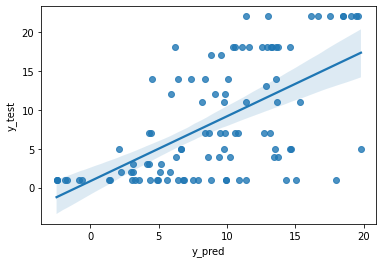

In [ ]:
sns.regplot(y_predt, Y_test_lr)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()
#Como podemos ver, obedece mejor a una sigmoide que a una recta.

Como se puede ver, dada la distribución de las muestras y por mucho que queramos añadir una variable sintética, el modelado de la frontera de decisión es mucho más eficaz usando otro tipo de regresiones, como la logística.

In [ ]:
#A continuación, añadimos otro tipo de regresiones basadas en Ridge, Lasso y Elastic
#Net, para observar en qué medida podrían mejorar el modelo.
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
#Comenzamos con el modelo de Lasso.
regressor = Lasso()
scores_ecm = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(regressor, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))
#Esperamos, de media, un ECM de 45 y un R2 de 0.04.


regressor = regressor.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

#Obtenemos 50.19 de ECM y 0.13 de R2 si lo hacemos todo con todo.
#Vemos que responde mal a test, no está correctamente generalizado.
#Esto es, de nuevo, debido al uso de la regresión lineal y la variable sintética.

ECM Scores: [-45.78450898 -45.45287062 -48.35430728 -42.0396153  -45.36083168]
R2 Scores : [ 0.03001899  0.04499514 -0.02031431  0.04755157  0.05524312]
45.39842676856487
0.039624625793214595
52.38708491923674
0.04196652397566525


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


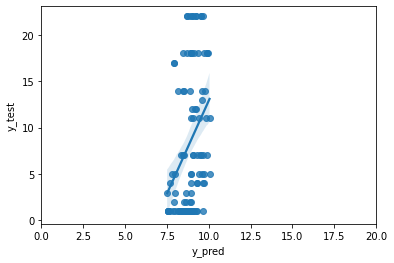

In [ ]:
#Representamos Lasso.
sns.regplot(y_predt, Y_test_lr)
plt.xlabel('y_pred')
plt.xlim(0, 20)
plt.ylabel('y_test')
plt.show()

In [ ]:
#Ridge
ridge = Ridge()
scores_ecm = cross_val_score(ridge, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(ridge, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))
#Esperamos, de media, un ECM de 32.11 y un R2 de 0.32.


regressor = ridge.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

#Obtenemos 55.18 de ECM y 0.045 de R2 si lo hacemos todo con todo.
#Vemos que responde mal a test, no está correctamente generalizado.
#Esto es, de nuevo, debido al uso de la regresión lineal y la variable sintética.

ECM Scores: [-40.38145166 -31.09863998 -30.05375587 -35.18752029 -39.033478  ]
R2 Scores : [0.14448703 0.34659017 0.36584187 0.20279246 0.18702666]
35.15096915954133
0.24934763619157727
52.38708491923674
0.04196652397566525


In [ ]:
lista = [X_train_lr['proba-of-rec'], X_train_lr['sex']]
prueba = pd.concat(lista, axis=1)

lista1 = [X_test_lr['proba-of-rec'], X_test_lr['sex']]
prueba2 = pd.concat(lista1, axis = 1)

regressor = ridge.fit(prueba,Y_train_lr) 
y_pred = regressor.predict(prueba2)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

47.598881244459406
0.12953122465583167


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


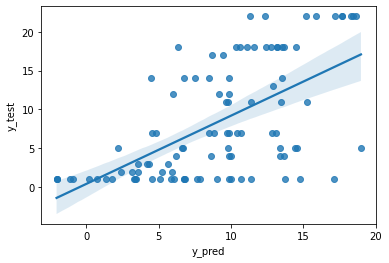

In [ ]:
sns.regplot(y_predt, Y_test_lr)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
#ElasticNet
elasticnet = ElasticNet()
scores_ecm = cross_val_score(elasticnet, X_train_lr, Y_train_lr, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(elasticnet, X_train_lr, Y_train_lr, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))
#Esperamos, de media, un ECM de 43.29 y un R2 de 0.08.


regressor = elasticnet.fit(X_train_lr,Y_train_lr) 
y_predt = regressor.predict(X_test_lr)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

#Obtenemos 50.18 de ECM y 0.13 de R2 si lo hacemos todo con todo.
#Vemos que responde mal a test, no está correctamente generalizado.
#Esto es, de nuevo, debido al uso de la regresión lineal y la variable sintética.

ECM Scores: [-44.7005487  -42.85497414 -45.27812355 -40.48519427 -44.63712801]
R2 Scores : [0.05298354 0.09957923 0.04459561 0.08276849 0.07031613]
43.591193733787264
0.07004860019704581
47.598881244459406
0.12953122465583167


In [ ]:
lista = [X_train_lr['proba-of-rec'], X_train_lr['sex']]
prueba = pd.concat(lista, axis=1)

lista1 = [X_test_lr['proba-of-rec'], X_test_lr['sex']]
prueba2 = pd.concat(lista1, axis = 1)

regressor = elasticnet.fit(prueba,Y_train_lr) 
y_pred = regressor.predict(prueba2)

# Calculamos el error cuadrático medio
mse=mean_squared_error(Y_test_lr, y_pred)

print(mse)

# Calculamos R^2
r_squared=r2_score(Y_test_lr, y_pred)
print(r_squared)

52.26139391137089
0.044265109463984986


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


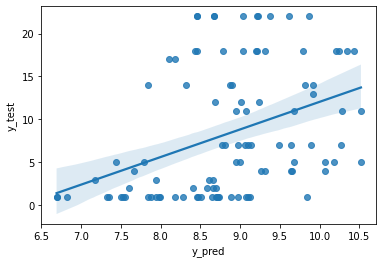

In [ ]:
sns.regplot(y_predt, Y_test_lr)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

#Regresión logística


ECM Scores: [-36.16666667 -41.46296296 -56.03773585 -65.09433962 -84.81132075]
R2 Scores : [ 0.22046301  0.0760166  -0.22869052 -0.35072245 -0.67072247]
56.71460517120895
0.3093230112576045


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[12  0  0  3  1  0  0  1  1  0  0  1]
 [ 0  1  2  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  1  1  0  1]
 [ 1  0  0  0  0  0  0  1  0  0  2  1]
 [ 1  1  0  0  3  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  3  0]
 [ 1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  3  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7]]


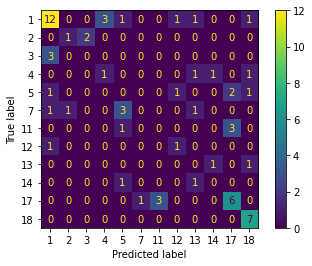

Accuracy: 0.417910447761194
Sensibilidad: 0.417910447761194


In [ ]:
#A continuación, procedemos a trabajar con nuestra base de datos real, sin tener
#en cuenta la variable sintética.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

#Dividimos los datos en entrenamiento y test.

output = completed_dataset['class']
input = completed_dataset.drop(columns='class')

X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size = 0.2, random_state = 42)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train_lr, Y_train_lr)
train = []
validation = []

for train_index, validation_index in skf.split(X_train, Y_train):
  train_groups= []
  validation_groups= []
  train_groups.append(train_index)
  validation_groups.append(validation_index)
  train.append(train_groups)
  validation.append(validation_groups)
  
#Usaremos el solver Saga, que es un acrónimo para el descenso estocástico por gradientes.


regressor = LogisticRegression(multi_class = 'multinomial', max_iter=1000, solver = 'saga' , penalty = 'none', n_jobs = -1)
scores_ecm = cross_val_score(regressor, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(regressor, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))

mse_results = []
r2_results = []

regressor = regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)

#Calculamos la matriz de confusión
cm = confusion_matrix(Y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regressor.classes_)
disp.plot()
plt.show()

#Calculamos la precisión.
precision=accuracy_score(Y_test, y_pred)
print('Precisión: {}'. format(precision))          
#Calculamos la sensibilidad
sensibilidad=recall_score(Y_test, y_pred, average = 'weighted')
print('Sensibilidad: {}'.format(sensibilidad))

Debido a la elevada cantidad de clases que disponemos, la representación del modelo de regresión logística múltiple se vuelve impracticable. Esto puede ser una limitación de nuestro estudio. Más adelante, trabajando en el balanceo de nuestra base de datos, podremos considerar disminuir aún más el número de clases
para mejorar en este aspecto.

A la hora de tratar la dimensionalidad, podríamos disminuirla mediante el uso de regresiones logísticas univariantes entre categorías. Sin embargo, debido a la baja correlación que presentan y que no tenemos un problema real con la misma (número de muestras >> 10 veces el número de dimensiones), no lo vemos 
necesario a priori.

Por último, y en relación a lo descrito en el primer apartado, disminuir el número de clases podría provocar una mayor incertidumbre acerca del cáncer que se está prediciendo.
Por tanto, habrá que llegar a un compromiso entre la reducción del número de clases y la incertidumbre/generalización entre tipo de cánceres a predecir.




ECM Scores: [-35.33333333 -43.59259259 -57.0754717  -63.18867925 -80.43396226]
R2 Scores : [ 0.23842469  0.02855876 -0.25144405 -0.31117956 -0.58449163]
55.92480782669462
0.28281974108136854
[[12  0  0  3  1  0  0  1  1  0  0  1]
 [ 0  1  2  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  1  1  0  1]
 [ 1  0  0  0  0  0  0  1  0  0  2  1]
 [ 1  1  0  0  3  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  3  0]
 [ 1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  2  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7]]


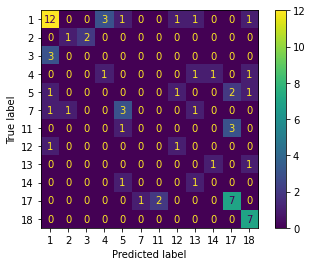

Precisión: 0.43283582089552236
Sensibilidad: 0.43283582089552236


In [ ]:
#Aplicamos el modelo Lasso, con penalty L1 y un parámetro de regularización de 20, que es el que nos ofrece mejor rendimiento.
logreg = LogisticRegression(C = 20, solver='saga', penalty='l1', multi_class = 'multinomial', max_iter=2000, n_jobs = -1)

regressor=logreg.fit(X_train, Y_train)

y_pred_lasso = logreg.predict(X_test)
scores_ecm = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))

#  Calculamos la matriz de confusión
cm = confusion_matrix(Y_test, y_pred_lasso)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

# Calculamos la precisión.
precision=accuracy_score(Y_test, y_pred_lasso)
print('Precisión: {}'.format(precision))
              
#Calculamos la sensibilidad.
sensibilidad_lasso=recall_score(Y_test, y_pred_lasso, average = 'weighted')
print('Sensibilidad: {}'.format(sensibilidad_lasso))

ECM Scores: [-34.75925926 -33.35185185 -63.39622642 -51.58490566 -65.45283019]
R2 Scores : [ 0.2507983   0.25676905 -0.39003372 -0.07039861 -0.28937403]
49.709014675052416
0.2514747391849749
[[12  0  0  3  1  0  0  1  1  0  0  1]
 [ 0  3  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  2  1  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  2  1]
 [ 1  1  0  0  3  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  3  0]
 [ 1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  1  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  1  1  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7]]


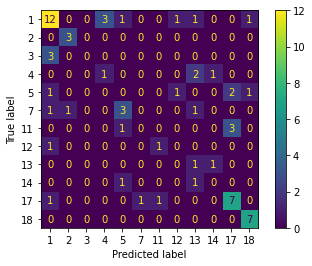

Precision: 0.4626865671641791
Sensibilidad: 0.4626865671641791


In [ ]:
#Aplicamos Ridge, con un penalty L2 y un parámetro de regularización de 10, que es el que nos ofrece mejor rendimiento.

logreg = LogisticRegression(C = 10, solver='saga', penalty='l2', multi_class = 'multinomial', max_iter=2000, n_jobs = -1)

regressor=logreg.fit(X_train, Y_train)

# Obtenemos la salida predicha
y_pred_ridge = logreg.predict(X_test)
scores_ecm = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))

#  Calculamos la matriz de confusión
cm = confusion_matrix(Y_test, y_pred_ridge)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

# Calculamos precisión.
precision=accuracy_score(Y_test, y_pred_ridge)
print('Precision: {}'.format(precision))

#Calculamos sensibilidad.
sensibilidad_ridge=recall_score(Y_test, y_pred_ridge, average = 'weighted')
print('Sensibilidad: {}'.format(sensibilidad_ridge))

ECM Scores: [-34.74074074 -33.35185185 -60.28301887 -51.58490566 -65.45283019]
R2 Scores : [ 0.25119745  0.25676905 -0.32177314 -0.07039861 -0.28937403]
49.08266946191475
0.2379024519839076
[[12  0  0  3  1  0  0  1  1  0  0  1]
 [ 0  3  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  2  1  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  2  1]
 [ 1  1  0  0  3  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  3  0]
 [ 1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  1  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  1  1  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7]]


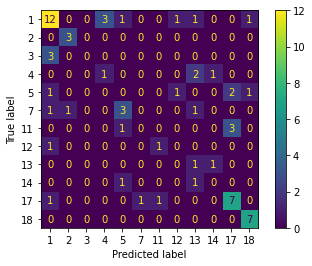

Precision: 0.4626865671641791
Sensibilidad: 0.4626865671641791


In [ ]:
#Por último, aplicamos ElasticNet, con un l1_ratio de 0.15 para expresar un tradeoff entre los dos tipos de modelo anteriores. El parámetro de 
#regularización que utilizaremos será de 10 dado que es el que nos ofrece mejor rendimiento.

logreg = LogisticRegression(C = 10, solver='saga', penalty='elasticnet', multi_class = 'multinomial', max_iter=2000, n_jobs = -1, l1_ratio = 0.15)


regressor=logreg.fit(X_train, Y_train)

#Obtenemos la salida predicha.
y_pred_en = logreg.predict(X_test)
scores_ecm = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'neg_mean_squared_error', n_jobs = -1)
scores_r2 = cross_val_score(logreg, X_train, Y_train, cv=skf, scoring = 'r2', n_jobs = -1)


print("ECM Scores: {}".format(scores_ecm))
print('R2 Scores : {}'.format(scores_r2))
print(np.mean(np.absolute(scores_ecm)))
print(np.mean(np.absolute(scores_r2)))

#Calculamos la matriz de confusión
cm = confusion_matrix(Y_test, y_pred_en)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

#Calculamos la precisión
precision=accuracy_score(Y_test, y_pred_en)
print('Precision: {}'.format(precision))
            
#Calculamos la sensibilidad
sensibilidad_en=recall_score(Y_test, y_pred_en, average = 'weighted')
print('Sensibilidad: {}'.format(sensibilidad_en))